# Step0 - Import Libraries, Load Data

Load the data and create train and test sets for internal validation.

Not all features provided are used for the model. Include information that is available before making the promotional call. For instance, “duration” feature should definitely NOT be used as we don’t know the duration of the call before the call has been made.


In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.pipeline import make_pipeline 
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import train_test_split, cross_val_predict, cross_val_score, GridSearchCV
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import LabelEncoder, scale, StandardScaler, PolynomialFeatures,Normalizer
from sklearn.feature_selection import f_classif, mutual_info_classif, VarianceThreshold, SelectPercentile, SelectKBest
from sklearn.decomposition import PCA
from sklearn.linear_model import RidgeClassifier, RidgeClassifierCV, LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, GradientBoostingClassifier, AdaBoostClassifier, ExtraTreesClassifier, BaggingClassifier
from imblearn.pipeline import make_pipeline as make_imb_pipeline
from imblearn.over_sampling import RandomOverSampler
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_auc_score

In [10]:
bank = pd.read_csv('data/data.csv')

# Step1 - Exploration and Preparation

Look into the data and try to understand it before modeling. Make some basic data preparation steps which are common across the two model sets required.

In [11]:
# unbalance data
sum(bank['subscribed']=="yes") # 3721
sum(bank['subscribed']=="no")  # 29238
no_bank = bank.subscribed.isnull()
no_bank.value_counts()         # no missing values
df_bank = bank[~no_bank]
# change y to {0,1}
sub = df_bank.subscribed
le = LabelEncoder()
le.fit(['yes','no'])
sub = le.transform(sub)
data = df_bank.drop("subscribed", axis=1)
data = data.drop("duration", axis=1)   # not need

In [12]:
# most are not contacted before, change to binary
print("original", data['prev_days'].value_counts()) # #999:28423, 96%
condition = data['prev_days'] == 999
data.loc[condition, 'prev_days'] = 0
data.loc[-condition, 'prev_days'] = 1
print("impute", data['prev_days'].value_counts())

# most are not contacted before, change to binary
print("original", data['prev_contacts'].value_counts()) # #0:31707, 86%
condition = data['prev_contacts'] == 0
data.loc[condition, 'prev_contacts'] = 0
data.loc[-condition, 'prev_contacts'] = 1
print("impute", data['prev_contacts'].value_counts())

# change 'no' and 'yes' as 'known', which is the most frequent
print("original", data.credit_default.value_counts())  # unknown:20%
condition = data['credit_default'] =='yes'
condition1 = data['credit_default'] =='no'
data.loc[condition, 'credit_default'] = 'known'
data.loc[condition1, 'credit_default'] = 'known'
print("impute", data.credit_default.value_counts())
#data = data.drop(data[data.credit_default == 'yes'].index)

# impute unknown housing by yes, which is the most frequent
print("original", data.housing.value_counts()) # unknown: 800
condition = data['housing'] =='unknown'
data.loc[condition, 'housing'] = 'yes'
print("impute", data.housing.value_counts())

# reclassify the levels of education, no big difference between 4,6,9 yr
print("original", data.education.value_counts())  # unknown:20%
condition1 = data['education'] =='basic.4y'
condition2 = data['education'] =='basic.6y'
condition3 = data['education'] =='basic.9y'
#condition4 = data['education'] =='illiterate'
#condition5 = data['education'] =='high.school'
data.loc[condition1, 'education'] = 'low'
data.loc[condition2, 'education'] = 'low'
data.loc[condition3, 'education'] = 'low'
#data.loc[condition4, 'education'] = 'low'

print("impute", data.education.value_counts())

# get dummies for categorical features
data_dummies = pd.get_dummies(data, columns = ['job','marital_status','education',
                                               'credit_default','housing','loan',
                                               'contact','month','day_of_week', 'prev_days',
                                               'prev_contacts','prev_outcomes'])


original 999    31707
3        373
6        332
4        105
9         55
7         48
2         46
12        45
5         42
10        40
13        26
11        23
1         19
15        18
14        17
8         13
0         11
16        10
17         5
18         4
19         3
22         3
21         2
26         1
20         1
27         1
Name: prev_days, dtype: int64
impute 0    31707
1     1243
Name: prev_days, dtype: int64
original 0    28423
1     3670
2      606
3      170
4       58
5       17
6        5
7        1
Name: prev_contacts, dtype: int64
impute 0    28423
1     4527
Name: prev_contacts, dtype: int64
original no         26059
unknown     6888
yes            3
Name: credit_default, dtype: int64
impute known      26062
unknown     6888
Name: credit_default, dtype: int64
original yes        17176
no         14974
unknown      800
Name: housing, dtype: int64
impute yes    17976
no     14974
Name: housing, dtype: int64
original university.degree      9760
high.school  

In [13]:
data_dummies.shape

(32950, 60)

In [14]:
# split to test set and train set
data_train, data_test, sub_train, sub_test = train_test_split(data_dummies,  sub, stratify=sub, random_state=1)

In [15]:
# imbalanced data
smote = SMOTE()
data_train_smote, sub_train_smote = smote.fit_sample(data_train, sub_train)

In [16]:
rus = RandomUnderSampler()
data_train_rus, sub_train_rus= rus.fit_sample(data_train, sub_train)

ros = RandomOverSampler()
data_train_ros, sub_train_ros = ros.fit_sample(data_train, sub_train)

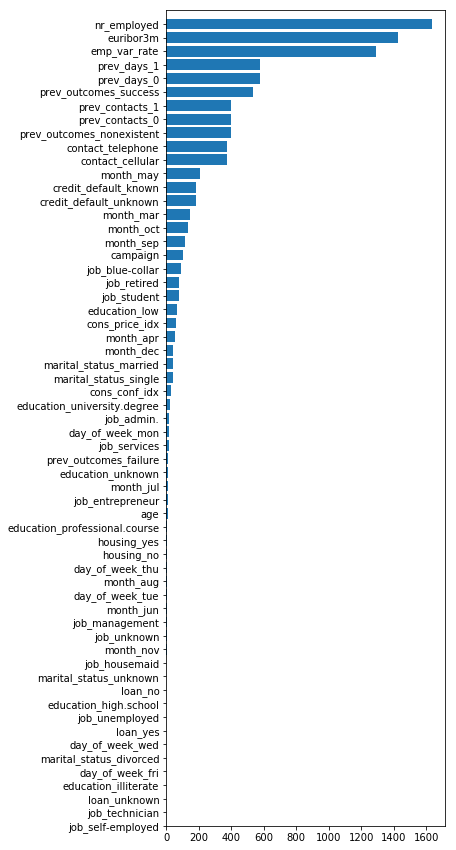

In [17]:
# feature information
F, p = f_classif(data_train_rus, sub_train_rus)

top_n = 60
inds = np.argsort(F)
plt.figure(figsize=(5, 15))
plt.barh(np.arange(top_n), F[inds[-top_n:]])
plt.yticks(np.arange(top_n), data_train.columns[inds[-top_n:]])
plt.ylim(0, top_n)
plt.show()

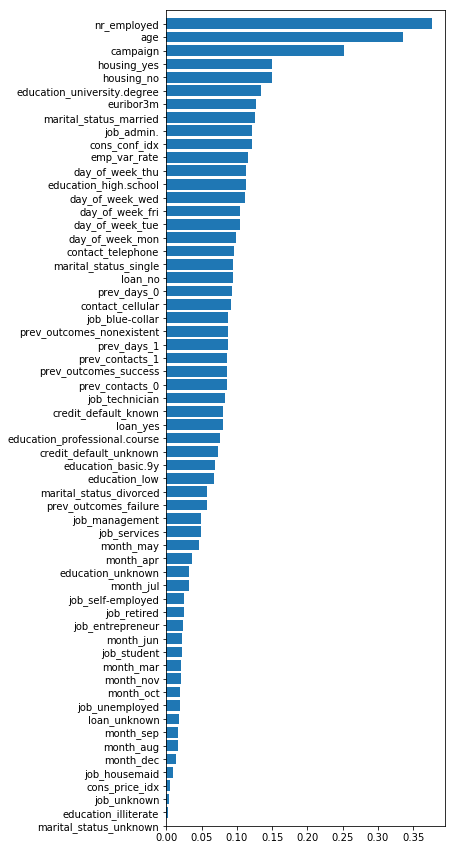

In [52]:
mi = mutual_info_classif(data_train_smote, sub_train_smote)
inds = np.argsort(mi)
plt.figure(figsize=(5, 15))
plt.barh(np.arange(len(mi)), mi[inds])
plt.yticks(np.arange(len(mi)), data_train.columns[inds])
plt.ylim(0, len(mi))
plt.show()

# Step2 - ModelSet1 

Perform the following steps relevant to the models for set1:

* feature engineering
* validation
* feature selection
* final model selection


In [ ]:
# no predict_proba, not work 
ridge_pca_pipe = make_pipeline(StandardScaler(), PCA(), PolynomialFeatures(interaction_only=True), 
                             VarianceThreshold(), RidgeClassifier())
ridge_pca_para = {'pca__n_components': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
            'polynomialfeatures__degree': [1, 2]}
ridge_pca_grid = GridSearchCV(ridge_pca_pipe, ridge_pca_para, cv=5, scoring='roc_auc')
ridge_pca_grid.fit(data_train_smote, sub_train_smote)
print(ridge_pca_grid.score(data_train_smote, sub_train_smote))
print(ridge_pca_grid.score(data_test, sub_test))
ridge_pca_grid.best_params_

In [96]:
lr_f_pipe = make_imb_pipeline(RandomUnderSampler(), StandardScaler(),SelectPercentile(score_func=f_classif), 
                         PolynomialFeatures(interaction_only=True), VarianceThreshold(), LogisticRegression())
lr_f_param = {'selectpercentile__percentile': [5, 10, 20, 30, 40, 50], 'polynomialfeatures__degree': [1, 2],
             'logisticregression__C': [.1, 1, 10, 100], 'logisticregression__penalty': ['l1', 'l2']}
lr_f_grid = GridSearchCV(lr_f_pipe, lr_f_param, cv=5, scoring='roc_auc')
lr_f_grid.fit(data_train, sub_train)

print(lr_f_grid.score(data_train, sub_train))
print(lr_f_grid.score(data_test, sub_test))
lr_f_grid.best_params_

0.809160540734
0.794498561253


{'logisticregression__C': 0.1,
 'logisticregression__penalty': 'l1',
 'polynomialfeatures__degree': 2,
 'selectpercentile__percentile': 40}

In [ ]:
svc_param = {'pca__n_components': np.arange(5,45,5)}
svc_pipe = make_imb_pipeline(StandardScaler(), RandomUnderSampler(replacement=False), PCA(), SVC())
svc_pca = GridSearchCV(svc_pipe, param_grid=svc_param, cv=10, scoring='roc_auc')
svc_pca.fit(data_train, sub_train)

print(svc_pca.score(data_train,sub_train))
print(svc_pca.score(data_test,sub_test))
svc_pca.best_params_
#SVC, n_components = 40

In [11]:
svc = SVC(gamma=.05, C=10).fit(data_train_smote, sub_train_smote)
print(svc.score(data_train_smote,sub_train_smote))
print(svc.score(data_test,sub_test))

0.99833546151
0.855304685603


# Step3 - ModelSet2 

Perform the following steps relevant to the models chose for set2:

* feature engineering
* validation
* feature selection
* final model selection

Try on decition tree, random forest and gradient boosted tree methods here and pick the one that works best.

In [102]:
rf_f_pipe = make_imb_pipeline(RandomUnderSampler(), Normalizer(), SelectPercentile(score_func=f_classif), 
                         PolynomialFeatures(interaction_only=True), VarianceThreshold(), RandomForestClassifier())
rf_f_param = {"normalizer": [None, Normalizer()],
              'selectpercentile__percentile': [10, 20, 30, 40, 50], 
              'polynomialfeatures__degree': [1, 2],
              'randomforestclassifier__n_estimators': np.arange(10,110,10), 
              'randomforestclassifier__min_samples_split': [10, 50,100]}
rf_f_grid = GridSearchCV(rf_f_pipe, rf_f_param, cv=10, scoring='roc_auc')
rf_f_grid.fit(data_train, sub_train)

print(rf_f_grid.score(data_train, sub_train))
print(rf_f_grid.score(data_test, sub_test))
rf_f_grid.best_params_

0.884293148864
0.796562116727


{'normalizer': Normalizer(copy=True, norm='l2'),
 'polynomialfeatures__degree': 2,
 'randomforestclassifier__min_samples_split': 50,
 'randomforestclassifier__n_estimators': 40,
 'selectpercentile__percentile': 50}

In [ ]:
rf_smote_pipe = make_imb_pipeline(StandardScaler(), SMOTE(), RandomForestClassifier(max_features=40))
rf_smote_param = {'randomforestclassifier__n_estimators':  np.arange(10, 110, 10)}
rf_smote_grid = GridSearchCV(rf_smote_pipe, param_grid=rf_smote_param, cv=10)
rf_smote_grid.fit(data_train, sub_train)
print(rf_smote_grid.best_score_)
print(rf_smote_grid.best_params_)
print(rf_smote_grid.score(X_test, y_test))
#Random Forest, n_estimators = 100

In [ ]:
gbc_pipe = make_imb_pipeline(StandardScaler(), RandomUnderSampler(replacement=False), GradientBoostingClassifier(random_state=0))
gbc_param = {'gradientboostingclassifier__n_estimators':  np.arange(10, 110, 10),
             'gradientboostingclassifier__max_features': [30, 35, 40, 45, 50]}
gbc_grid = GridSearchCV(pipe, param_grid=param_grid, cv=10, scoring = 'roc_auc')
gbc_grid.fit(X_train, y_train)
print(gbc_grid.best_score_)
print(gbc_grid.best_params_)
print(gbc_grid.score(X_test, y_test))

#{'gradientboostingclassifier__max_features': 40, 
#'gradientboostingclassifier__n_estimators': 60}

In [ ]:
gbc_smote_pipe = make_imb_pipeline(StandardScaler(), SMOTE(), GradientBoostingClassifier(max_features=40))
gbc_smote_param_grid = {'gradientboostingclassifier__n_estimators':  np.arange(10, 110, 10)}
gbc_smote_grid = GridSearchCV(gbc_smote_pipe, param_grid=pgbc_smote_para, cv=10)
gbc_smote_grid.fit(data_train, sub_train)
print(gbc_smote_grid.best_score_)
print(gbc_smote_grid.best_params_)
print(gbc_smote_grid.score(X_test, y_test))
#Gradient Boosting, n_estimators=100

In [ ]:
etc_f_pipe = make_pipeline(RandomUnderSampler(), Normalizer(), SelectPercentile(score_func=f_classif), 
                         PolynomialFeatures(interaction_only=True), VarianceThreshold(), ExtraTreesClassifier())
etc_f_param = {"normalizer": [None, Normalizer()],
              'selectpercentile__percentile': [10, 20, 30, 40, 50], 
              'polynomialfeatures__degree': [1, 2],
              'extratreesclassifier__n_estimators': np.arange(10,110,10), 
              'extratreesclassifier__min_samples_split': [10,50,100,200]}
etc_f_grid = GridSearchCV(etc_f_pipe, etc_f_param, cv=10, scoring='roc_auc')
etc_f_grid.fit(data_train, sub_train)

print(etc_f_grid.score(data_train, sub_train))
print(etc_f_grid.score(data_test, sub_test))
etc_f_grid.best_params_



In [ ]:
bc_f_pipe = make_pipeline(RandomUnderSampler(), Normalizer(), SelectPercentile(score_func=f_classif), 
                         PolynomialFeatures(interaction_only=True), VarianceThreshold(), BaggingClassifier())
bc_f_param = {"normalizer": [None, Normalizer()],
              'selectpercentile__percentile': [10, 20, 30, 40, 50], 
              'polynomialfeatures__degree': [1, 2],
              'baggingclassifier__n_estimators': np.arange(10,110,10), 
              'baggingclassifier__min_samples_split': [50, 100, 200, 300]}
bc_f_grid = GridSearchCV(bc_f_pipe, bc_f_param, cv=10, scoring='roc_auc')
bc_f_grid.fit(data_train, sub_train)

print(bc_f_grid.score(data_train, sub_train))
print(bc_f_grid.score(data_test, sub_test))
bc_f_grid.best_params_


# Step4 - Ensemble 

Use the models created before and create new predictions. Try poor man's stacking.

Report the test error using area under the ROC curve.

In [ ]:
# RandomUnderSampler() runs faster than SMOTE() and RandomOverSampler(),
# and it works well, so we pick RandomUnderSampler() in the voting

In [18]:
lr_f = make_imb_pipeline(RandomUnderSampler(), SelectPercentile(percentile=40), PolynomialFeatures(degree=2, interaction_only=True),
                     VarianceThreshold(), LogisticRegression(C=.1, penalty='l1'))

svc_pca = make_imb_pipeline(StandardScaler(), RandomUnderSampler(replacement=False), PCA(n_components=40), 
                             SVC(probability=True))


rf_f= make_imb_pipeline(RandomUnderSampler(),SelectPercentile(percentile=50), PolynomialFeatures(interaction_only=True, degree=1), 
                    RandomForestClassifier(min_samples_split=100, n_estimators=80))

gbc_f = make_imb_pipeline(RandomUnderSampler(), StandardScaler(), RandomUnderSampler(replacement=False), 
                             GradientBoostingClassifier(learning_rate=.1, max_features=40, n_estimators=80))

voting = VotingClassifier([('lr_f', lr_f),
                           ('svc_pca', svc_pca),
                           ('rf_f', rf_f),
                           ('gbc_f', gbc_f)],
                          voting='soft', weights = [2,1,2,1])
voting.fit(data_train, sub_train)
lr_f,svc_f,rf_f,gbc_f = voting.estimators_
print(("{:.2f} " * 5).format(voting.score(data_test, sub_test), lr_f.score(data_test, sub_test),
                             svc_f.score(data_test, sub_test),rf_f.score(data_test, sub_test), 
                             gbc_f.score(data_test, sub_test)))




0.82 0.81 0.82 0.84 0.83 


In [19]:
sub_pred = voting.predict(data_test)
roc_auc = roc_auc_score(sub_test, sub_pred)
roc_auc

0.74664326737110231

In [ ]:
lr_f_smote = make_imb_pipeline(SMOTE(), SelectPercentile(percentile=40), PolynomialFeatures(degree=2, interaction_only=True),
                     VarianceThreshold(), LogisticRegression(C=.1, penalty='l1'))

svc_pca_smote = make_imb_pipeline(SMOTE(), StandardScaler(), 
                                  PCA(n_components=40), SVC(probability=True))


rf_f_smote= make_imb_pipeline(SMOTE(), SelectPercentile(percentile=50), PolynomialFeatures(interaction_only=True, degree=1), 
                    RandomForestClassifier(min_samples_split=100, n_estimators=80))

gbc_f_smote = make_imb_pipeline(SMOTE(), StandardScaler(), 
                             GradientBoostingClassifier(learning_rate=.1, max_features=40, n_estimators=80))

voting_smote = VotingClassifier([('lr_f', lr_f_smote),
                           ('svc_pca', svc_pca_smote),
                           ('rf_f', rf_f_smote),
                           ('gbc_f', gbc_f_smote)],
                          voting='soft', weights = [2,1,2,1])
voting_smote.fit(data_train, sub_train)
lr_f_smote,svc_f_smote,rf_f_smote,gbc_f_smote = voting.estimators_
print(("{:.2f} " * 5).format(voting_smote.score(data_test, sub_test), lr_f_smote.score(data_test, sub_test),
                             svc_f_smote.score(data_test, sub_test),rf_f_smote.score(data_test, sub_test), 
                             gbc_f_smote.score(data_test, sub_test)))





In [101]:
sub_pred = voting.predict(data_test)
roc_auc_score = roc_auc_score(sub_test, sub_pred)

0.74429970163686965

In [20]:
# load in holdout data set
hold = pd.read_csv("data/holdout.csv")
id_hold = hold['ID']
hold = hold.drop('ID', axis=1)
data_hold = hold.drop("duration", axis=1)   # not need

#update data formate to be the same as in the training set

data_hold['prev_days'].value_counts() 
condition = data_hold['prev_days'] == 999
data_hold.loc[condition, 'prev_days'] = 0
data_hold.loc[-condition, 'prev_days'] = 1
data_hold['prev_days'].value_counts()

# most are not contacted before, change to binary
print("original", data_hold['prev_contacts'].value_counts()) # #0:31707, 86%
condition = data_hold['prev_contacts'] == 0
data_hold.loc[condition, 'prev_contacts'] = 0
data_hold.loc[-condition, 'prev_contacts'] = 1
print("impute", data_hold['prev_contacts'].value_counts())

# change 'no' and 'yes' as 'known', which is the most frequent
print("original", data_hold.credit_default.value_counts())  # unknown:20%
condition = data_hold['credit_default'] =='yes'
condition1 = data_hold['credit_default'] =='no'
data_hold.loc[condition, 'credit_default'] = 'known'
data_hold.loc[condition1, 'credit_default'] = 'known'
print("impute", data_hold.credit_default.value_counts())

# impute unknown housing by yes, which is the most frequent
print("original", data_hold.housing.value_counts()) # unknown: 800
condition = data_hold['housing'] =='unknown'
data_hold.loc[condition, 'housing'] = 'yes'
print("impute", data_hold.housing.value_counts())

# reclassify the levels of education
print("original", data_hold.education.value_counts())  # unknown:10%
condition1 = data_hold['education'] =='basic.4y'
condition2 = data_hold['education'] =='basic.6y'
condition3 = data_hold['education'] =='basic.9y'
#condition4 = data_hold['education'] =='illiterate'
#condition5 = data_hold['education'] =='high.school'
data_hold.loc[condition1, 'education'] = 'low'
data_hold.loc[condition2, 'education'] = 'low'
data_hold.loc[condition3, 'education'] = 'low'
#data_hold.loc[condition4, 'education'] = 'low'
print("impute", data_hold.education.value_counts())

# get dummies for categorical features
data_hold_dummies = pd.get_dummies(data_hold, columns = ['job','marital_status','education',
                                                         'credit_default','housing','loan',
                                                         'contact','month','day_of_week', 'prev_days',
                                                         'prev_contacts','prev_outcomes'])

data_hold_dummies.shape

original 0    7140
1     891
2     148
3      46
4      12
5       1
Name: prev_contacts, dtype: int64
impute 0    7140
1    1098
Name: prev_contacts, dtype: int64
original no         6529
unknown    1709
Name: credit_default, dtype: int64
impute known      6529
unknown    1709
Name: credit_default, dtype: int64
original yes        4400
no         3648
unknown     190
Name: housing, dtype: int64
impute yes    4590
no     3648
Name: housing, dtype: int64
original university.degree      2408
high.school            1935
basic.9y               1156
professional.course    1089
basic.4y                863
basic.6y                446
unknown                 337
illiterate                4
Name: education, dtype: int64
impute low                    2465
university.degree      2408
high.school            1935
professional.course    1089
unknown                 337
illiterate                4
Name: education, dtype: int64


(8238, 60)

In [21]:
sub_hold = voting.predict_proba(data_hold_dummies)
output = pd.DataFrame(sub_hold[:,1], columns = ['subscribed'])
output = output.round(decimals=1)
result = pd.concat([id_hold, output], axis =1, join_axes=[id_hold.index])
result.to_csv('output.csv', index=False)
result.subscribed.value_counts()

0.3    3355
0.2    1944
0.4     989
0.8     513
0.5     469
0.9     432
0.7     274
0.6     235
1.0      27
Name: subscribed, dtype: int64

In [22]:
def test_auc():
    assert roc_auc >= .73



In [23]:
assert True